In [1]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [2]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

# Analysing proportional voting systems

We'll be using the case study of the Swedish parlimentary election systems, namely that there exists n-parties, voters vote for the preferred option (using the distance method we described earlier). The difference is the "winner" is not as well defined. 

In [3]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))

experiments = {
    "electorate_size": [10_000, 25_000, 50_000],
    "clusters": [1, 2, 5, 10],
    "cluster_std": [1, 2, 3],
    "electoral_system": ["proportional"],
    "apathy_prob": [0.0, 0.01, 0.05],
    "candidates": [2, 4, 5, 9], # akin to parties in the proportional case
    "issues": [2, 5, 10, 25],
    "seats": [150, 179, 349, 736], # dutch, danish, swedish, german parliment(s) seats
    "min_share_threshold": [0, 0.04, 0.10] # dutch, swedish, and turkish thresholds
}
records = []
columns = [*experiments.keys(), "unweighted_fairness", "weighted_fairness"]
experiment_matrix = list(generate_experiment_matrix(experiments))

for params in tqdm(experiment_matrix):

    # setup objects
    voters = electorate.setup_electorate(**params)
    parties = candidates.setup_candidates(**params, electorate=voters)
    system = voting_system.setup_voting_system(name=params["electoral_system"], **params)

    # simulate elections
    sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())

    result = sim.run()
    result_record = { 
        "unweighted_fairness": round(result.unweighted_fairness, 3),
        "weighted_fairness": round(result.weighted_fairness, 3),
        **params 
    }
    result_record = {k: v for k, v in result_record.items() if k in columns}
    records.append(result_record)

  0%|                                                  | 46/20736 [00:03<22:37, 15.24it/s]


KeyboardInterrupt: 

In [29]:
results_df = pd.DataFrame.from_records(records)
results_df

,unweighted_fairness,weighted_fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,seats,min_share_threshold
0,1.902,1.902,10000,1,1,proportional,0.00,2,2,150,0.00
1,1.758,1.758,10000,1,1,proportional,0.00,2,2,150,0.04
2,2.404,2.404,10000,1,1,proportional,0.00,2,2,150,0.10
3,3.949,3.949,10000,1,1,proportional,0.00,2,2,179,0.00
4,5.615,5.615,10000,1,1,proportional,0.00,2,2,179,0.04
...,...,...,...,...,...,...,...,...,...,...,...
20731,0.874,0.787,50000,10,3,proportional,0.05,9,25,349,0.04
20732,0.829,0.790,50000,10,3,proportional,0.05,9,25,349,0.10
20733,0.858,0.767,50000,10,3,proportional,0.05,9,25,736,0.00
20734,0.890,0.827,50000,10,3,proportional,0.05,9,25,736,0.04


In [4]:
filepath = "data/proportional-vs-proportional-df5ec973-c180-40ef-a410-1490716cd4e2.csv"
assert not os.path.isfile(filepath), "file already exists; use a new uuid to avoid overwriting"
results_df.to_csv(filepath, index=False)

AssertionError: file already exists; use a new uuid to avoid overwriting

In [6]:
results_df = pd.read_csv(filepath)

**NOTE:** that unweighted fairness does not have any meaning in the proportional case and should not be used to compare between majority/plurality and proportionality electoral systems.

### Investigating factors of fairness

In [7]:
corr_df = results_df.drop(["electoral_system", "unweighted_fairness"], axis=1).corrwith(results_df.weighted_fairness)

In [8]:
df = pd.DataFrame(corr_df).drop("weighted_fairness", axis=0)
df.index = df.index.rename("measure")
df.columns = ["weighted_fairness"]
df = df.reset_index()

In [9]:
df

,measure,weighted_fairness
0,electorate_size,-0.001871
1,clusters,-0.502127
2,cluster_std,-0.254411
3,apathy_prob,0.001108
4,candidates,-0.036729
5,issues,0.045120
6,seats,-0.000267
7,min_share_threshold,0.000151


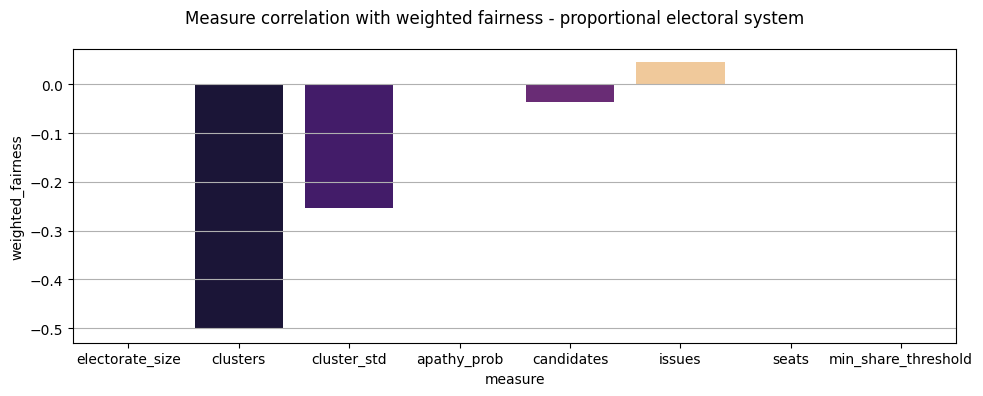

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
sns.barplot(data=df.reset_index(), x="measure", y="weighted_fairness", hue="weighted_fairness", palette="magma", ax=ax, dodge=False)
ax.get_legend().set_visible(False)
ax.grid(axis="y")
plt.suptitle("Measure correlation with weighted fairness - proportional electoral system")
plt.show()